## BBC News Classification Kaggle Mini-Project

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 

The part has 80 points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. 
Use Matrix Factorization to predict the category and submit your notebook for peer evaluation.



### Instructions: Step 1 - Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report. 

In [303]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Read Train and Test Data

In [304]:
# Read the training data
df_train = pd.read_csv('./Data/BBC News Train.csv')
# Read the test data
df_test = pd.read_csv('./Data/BBC News Test.csv')


In [305]:
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


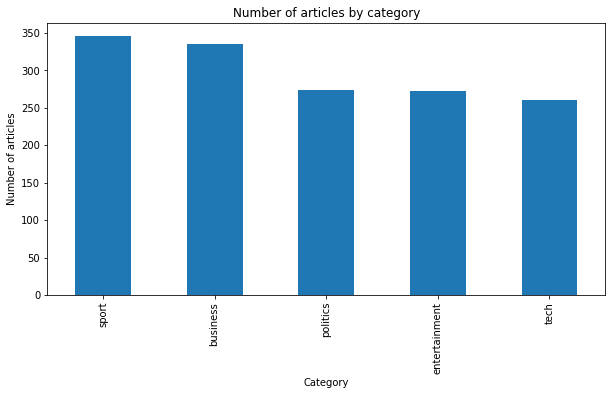

In [306]:
# display by category
df_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Number of articles by category')
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.show()

There are 5 categories : Business, Tech, Politics , Sports and Entertainment in Training Set.

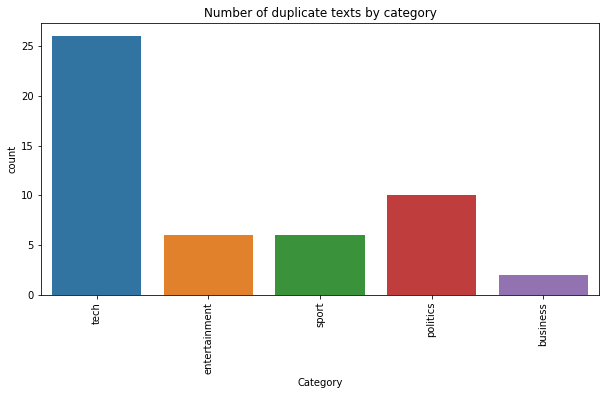

Total number of duplicate texts:  50


In [307]:

# Get the duplicate texts
dup_text = df_train[df_train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text').head(50)
# Plot the number of duplicate text by category
plt.figure(figsize=(10, 5))
# Title of the plot
plt.title('Number of duplicate texts by category')
sns.countplot(x='Category', data=dup_text)
plt.xticks(rotation=90)
plt.show()

# Total number of duplicate texts
print('Total number of duplicate texts: ', len(dup_text))


The training data has 1490 observations and 3 columns : Articleid, Text and Category. The Articleid is unique. There are 50 duplicate texts in training data.
Above bar chart shows duplicate text by category.

In [308]:
# Remove the duplicate texts
df_train.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Reset the index
df_train.reset_index(drop=True, inplace=True)

# Print the shape of the training data
print('Shape of the training data: ', df_train.shape)

Shape of the training data:  (1440, 3)


In [309]:
#Manually encode the target variable
df_train['Category'] = df_train['Category'].map({'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})
# Print the first 3 rows of the training data
df_train.head(5)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,4
4,917,enron bosses in $168m payout eighteen former e...,0


Let's examine sample data from "Text" column. We want to ensure that the data has english words without any common words (stop words), special characters, comma's, punctuations etc.


In [310]:
# Print text of the first row
df_train['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

There are special characters, full stops, numbers etc. Also lot of stop words e.g "to" , "and" etc. We don't want to skew results by including these characters in the model.

We will use Python's Natulral Language Toolkit (nltk) : https://www.nltk.org/ , to analyze text data. 

In [311]:
# Write function to clean the text

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert all characters to lowercase
    text = text.lower()
    # Split the text into words
    text = text.split()
    # Remove stopwords
    text = [word for word in text if not word in set(stopwords.words('english'))]
    # Stem the words
    # ps = PorterStemmer()
    # text = [ps.stem(word) for word in text]
    # Join the words
    text = ' '.join(text)
    return text




[nltk_data] Downloading package stopwords to /Users/kgb-
[nltk_data]     mini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [312]:
# Clean the text
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

Now that we cleaned text. Next step is to tokenize and lemmatize data. We will use NLTK to tokenize each article into a list of words. To tokenize, we use 'word_tokenize'
function from NLTK.

Lemmatization is a process of reducing each work to its base or dictionary form. For example, the words "running" and "ran" would both be reduce to the base form run. 


Ensure to install NLTK Data using following commend in macos
python3 -m nltk.downloader popular

In [313]:
# Tokenize and lemmatising the text
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the words
    text = ' '.join(text)
    return text

# Lemmatize the text
df_train['Text'] = df_train['Text'].apply(lemmatize_text)
df_test['Text'] = df_test['Text'].apply(lemmatize_text)

# Print the first row of the training data
df_train['Text'][0]


'worldcom ex bos launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom ex head internal accounting alerted director irregular accounting practice u telecom giant warning led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial chief scott sullivan

##### Original Text
------------------------------------------------------------------------------------------------------------------------------------
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud.



##### After Lemmanization
------------------------------------------------------------------------------------------------------------------------------------
worldcom ex bos launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom ex head internal accounting alerted director irregular accounting practice u telecom giant warning led collapse firm following discovery bn bn accounting fraud 


In [314]:
X_train = df_train['Text']
y_train = df_train['Category']
X_test = df_test['Text']


### Instructions: Step 2  - Building and Training Models [35 pts]

In the Kaggle competition, the training data has labels (category). Thus, it can be solved using supervised learning. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. This assignment will apply an unsupervised approach, especially the matrix factorization method, to discover topics in the news articles and use the labels to check the accuracy.

Here are some steps to guide this section: 
1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 

Below code uses TfidVectorizer from scikit-learn library to vectorize the text of news articles into a document-term
matrix. The document-term matrix represents the frequency of each term in each document (news article) weigheted by their
inverse document frequency (IDF). The resulting matrix can be used as input to train a machine learning mode.

1. First, the TfidfVectorizer class is imported from scikit-learn.
2. An instance of the TfidfVectorizer is created with some parameters. The 'stop_words' parameter is set to 'english', which removes common English stop words from the text. The 'max_features' parameter is set to 1000, which limits the number of terms to the 1000 most frequent terms.
3. The vectorizer is fit to the training data by calling the 'fit' method with the text data from the training dataset.
4. The 'transform' method of the vectorizer is then called on the text data from both the training and test datasets to obtain the document-term matrix for each dataset.
5. Finally, the shape of the training and test data matrices are printed to the console.

In [315]:
# Use TF-IDF to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
# Create an instance of the TfidfVectorizer. Performs the TF-IDF transformation from a provided matrix of counts.
tfidf = TfidfVectorizer(encoding = 'utf-8', ngram_range = (1,2),stop_words= None,lowercase = False, max_df = 0.95, 
                            min_df = 10,norm = 'l2',sublinear_tf = True)

# Fit the vectorizer to the training data
tfidvec_train = tfidf.fit_transform(X_train).toarray()
tokens = tfidf.get_feature_names_out()

print('Number of tokens: ', len(tokens))
print('Number of documents: ', len(tfidvec_train))
print('Number of features: ', len(tfidvec_train[0]))


Number of tokens:  4488
Number of documents:  1440
Number of features:  4488


In [316]:
print("Weights given to words by idf:")
pd.DataFrame(tfidf.idf_, tfidf.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
said,1.160765
year,1.413478
also,1.597269
would,1.662397
one,1.724873
...,...
surveyed,5.875197
middlesbrough,5.875197
robust,5.875197
drag,5.875197


Please note the shape of the resulting document-term matrix has more than 4000 features. To reduce dimenions, we can use Non-Negative matrix factorization (NMF) or Singular Value Decomposition (SVD) before being used as part of machine learning model.

In [317]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import NMF
from time import time


# Set the number of components and initialize the NMF model with given parameters
n_components = 5
nmf = NMF(n_components = 5, random_state = 42, solver = "mu", beta_loss = "kullback-leibler", max_iter= 1000)

# Fit the NMF model to the training data
model = nmf.fit(tfidvec_train)

# Transform the training data into W_train and H_train matrices
W_train = nmf.fit_transform(tfidvec_train)
H_train = nmf.components_

print("The size of W_train for training set is: ", W_train.shape)
print("The size of H_train for training is: ", H_train.shape)



The size of W_train for training set is:  (1440, 5)
The size of H_train for training is:  (5, 4488)


In [318]:
# Display the top 10 words for each topic
for topic_idx, topic in enumerate(H_train):
    print("Topic %d:" % (topic_idx))
    print(" ".join([tokens[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
bn company said firm market year share growth bank economy
Topic 1:
game win player match champion england team club injury cup
Topic 2:
mr election government labour minister party said blair would tory
Topic 3:
film award star best show actor year music band oscar
Topic 4:
people technology phone user mobile computer use service software said


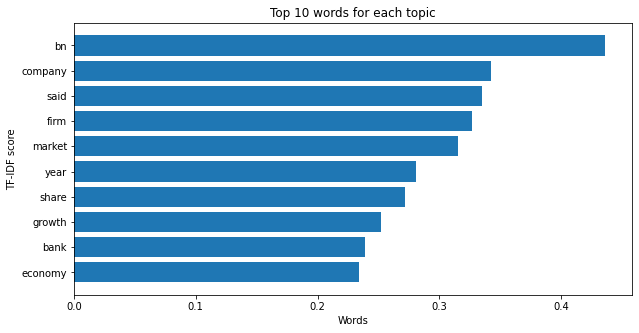

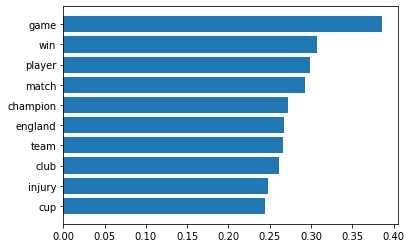

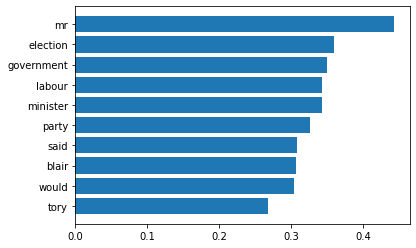

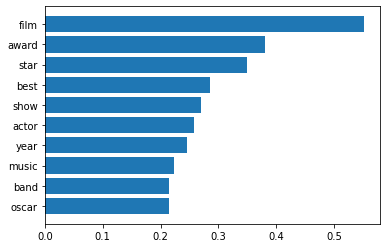

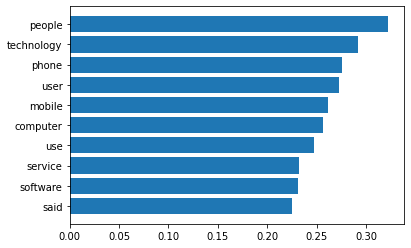

In [319]:
# Plot the top 10 words for each topic also dispay topic names
plt.figure(figsize=(10, 5))
plt.title('Top 10 words for each topic')
plt.xlabel('Words')
plt.ylabel('TF-IDF score')
for topic_idx, topic in enumerate(H_train):
    plt.barh(range(10), np.sort(topic)[-10:], align='center')
    plt.yticks(range(10), np.array(tokens)[np.argsort(topic)[-10:]])
    plt.show()


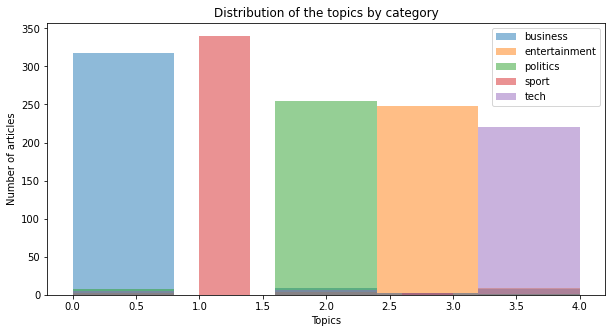

In [320]:
# Plot the distribution of the topics by category
plt.figure(figsize=(10, 5))
plt.title('Distribution of the topics by category')
plt.xlabel('Topics')
plt.ylabel('Number of articles')
plt.hist(np.argmax(W_train, axis=1)[y_train == 0], bins=5, alpha=0.5, label='business')
plt.hist(np.argmax(W_train, axis=1)[y_train == 1], bins=5, alpha=0.5, label='entertainment')
plt.hist(np.argmax(W_train, axis=1)[y_train == 2], bins=5, alpha=0.5, label='politics')
plt.hist(np.argmax(W_train, axis=1)[y_train == 3], bins=5, alpha=0.5, label='sport')
plt.hist(np.argmax(W_train, axis=1)[y_train == 4], bins=5, alpha=0.5, label='tech')

plt.legend()
plt.show()

In [321]:
#Write a method which takes W_train as input and returns the topic incides for each document in the training set sorted by the highest probability
def get_topic_indices(W_train):
    topic_indices = []
    for i in range(len(W_train)):
        topic_indices.append(np.argmax(W_train[i]))
    return topic_indices

# Get the topic indices for each document in the training set
topic_indices = get_topic_indices(W_train)


In [322]:

accuracy_score(y_train , topic_indices)

0.5513888888888889

The accuracy score based on above parameters is 55%. In order to find optimal permutation of predicted labels based on the training data, we can use brute-force method appraoch to try all possible permutations of the labels and choose the one that results in the highest accuracy. 

In [323]:
# Find the optimal permutation based on training data
# Get the permutation matrix
perm = np.array([np.argmax(np.bincount(y_train[np.argmax(W_train, axis=1) == i])) for i in range(n_components)])
# Permute the rows of W
W_perm = W_train[:, perm]
# Permute the rows of H
H_perm = nmf.components_[perm, :]

# Display accuracy score    
print('Accuracy score: ', accuracy_score(y_train, np.argmax(W_perm, axis=1)))

perm


Accuracy score:  0.9583333333333334


array([0, 3, 2, 1, 4])

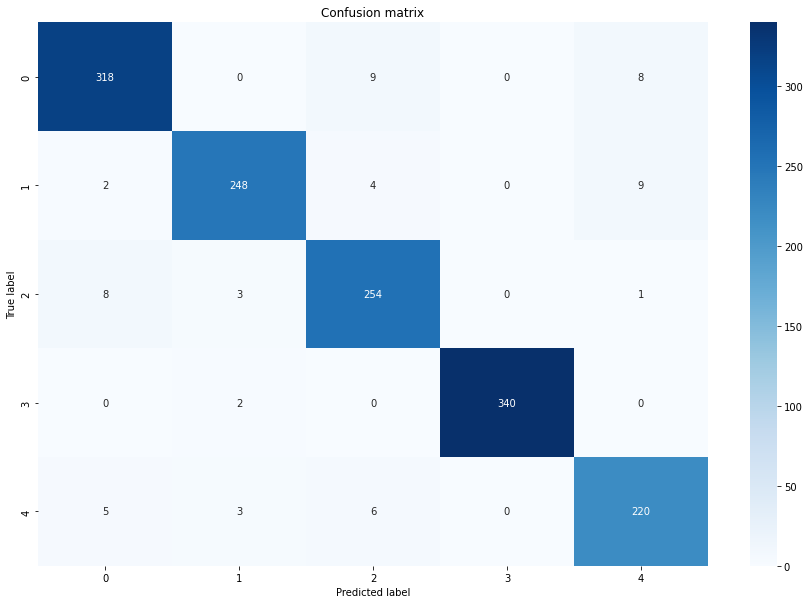

In [324]:
# Permute the rows of the confusion matrix
confusion_matrix_perm = confusion_matrix(y_train, np.argmax(W_perm, axis=1))
# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix_perm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [325]:
# Create a dataframe with articleid, text, category and predicted category
df_pred = pd.DataFrame({'ArticleId': df_train['ArticleId'], 'Text': df_train['Text'], 'Category': df_train['Category'], 'PredictedCategory': np.argmax(W_perm, axis=1)})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['Category'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
df_pred['PredictedCategory'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

,ArticleId,Text,Category,PredictedCategory
0,1833,worldcom ex bos launch defence lawyer defendin...,business,business
1,154,german business confidence slide german busine...,business,business
2,1101,bbc poll indicates economic gloom citizen majo...,business,business
3,1976,lifestyle governs mobile choice faster better ...,tech,tech
4,917,enron boss payout eighteen former enron direct...,business,business
5,1582,howard truanted play snooker conservative lead...,politics,politics
6,651,wale silent grand slam talk rhys williams say ...,sport,sport
7,1797,french honour director parker british film dir...,entertainment,entertainment
8,2034,car giant hit mercedes slump slump profitabili...,business,business
9,1866,fockers fuel festive film chart comedy meet fo...,entertainment,entertainment


In [326]:

# Create a dataframe with articleid, text, category and predicted category
tfidvec_test = tfidf.fit_transform(df_test['Text']).toarray()
y_test_hat = nmf.fit_transform(tfidvec_test)
#index with highest probability is our predicted class
y_test_hat = np.argmax(y_test_hat, axis=1)
# create dataframe
y_test_hat = pd.DataFrame(y_test_hat)

# assign best labelorder to prediction
y_test_hat = y_test_hat.replace(np.unique(y_test_hat), [0, 3, 2, 1, 4])
y_test_hat.head()

,0
0,3
1,1
2,3
3,0
4,3


In [327]:
# Create a dataframe with articleid, text and predicted category
df_pred = pd.DataFrame({'ArticleId': df_test['ArticleId'],  'PredictedCategory': y_test_hat[0]})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

# Remove predicted category column
df_pred.drop('PredictedCategory', axis=1, inplace=True)
# Print the first 15 rows of the dataframe
df_pred.head(15)



,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,tech
9,397,business


### Instructions: Step 3  - Compared with Supervised Learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

### Train Supervised Learning Methods

Below is a general supervised learning model which takes model, tfidf, X_train, X_test, y_train and y_test as arguments

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import logistic_regression

def evaluate_model(model, tfidf, X_train, X_test, y_train, y_test):
    # Transform the training and test set
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)
    # Fit the model on the training set
    model.fit(X_train, y_train)
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc, y_pred, y_test


ImportError: cannot import name 'logistic_regression' from 'sklearn.ensemble' (/usr/local/lib/python3.9/site-packages/sklearn/ensemble/__init__.py)

In [ ]:
# Create a tf-idf vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
# Fit the vectorizer on the entire dataset
tfidf.fit(df_train['Text'])

TfidfVectorizer(max_features=1000, stop_words='english')

### Create Random Forest Model

In [ ]:
# Create a random forest model
rf_model = RandomForestClassifier()
# Evaluate the random forest model with different values of size
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8]
rf_accs = []
for size in sizes:
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_train['Text'], df_train['Category'], train_size=size, random_state=42)
    acc, y_pred, y_test = evaluate_model(rf_model, tfidf, X_train, X_test, y_train, y_test)
    rf_accs.append(acc)
    print('Random forest accuracy score for size {}: {}'.format(size, acc))


Random forest accuracy score for size 0.1: 0.9050925925925926
Random forest accuracy score for size 0.2: 0.9053819444444444
Random forest accuracy score for size 0.3: 0.9186507936507936
Random forest accuracy score for size 0.4: 0.9305555555555556
Random forest accuracy score for size 0.5: 0.9319444444444445
Random forest accuracy score for size 0.6: 0.9513888888888888
Random forest accuracy score for size 0.7: 0.9422632794457275
Random forest accuracy score for size 0.8: 0.9479166666666666


### Create Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
lr_model = LogisticRegression()
# Evaluate the logistic regression model with different values of size
lr_accs = []
for size in sizes:
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_train['Text'], df_train['Category'], train_size=size, random_state=42)
    acc, y_pred, y_test = evaluate_model(lr_model, tfidf, X_train, X_test, y_train, y_test)
    lr_accs.append(acc)
    print('Logistic regression accuracy score for size {}: {}'.format(size, acc))


Logistic regression accuracy score for size 0.1: 0.9166666666666666
Logistic regression accuracy score for size 0.2: 0.9357638888888888
Logistic regression accuracy score for size 0.3: 0.9494047619047619
Logistic regression accuracy score for size 0.4: 0.9560185185185185
Logistic regression accuracy score for size 0.5: 0.9555555555555556
Logistic regression accuracy score for size 0.6: 0.9600694444444444
Logistic regression accuracy score for size 0.7: 0.9630484988452656
Logistic regression accuracy score for size 0.8: 0.9548611111111112


### Create Support Vector Machines

Support vector classifier accuracy score for size 0.1: 0.9143518518518519
Support vector classifier accuracy score for size 0.2: 0.9288194444444444
Support vector classifier accuracy score for size 0.3: 0.9603174603174603
Support vector classifier accuracy score for size 0.4: 0.9652777777777778
Support vector classifier accuracy score for size 0.5: 0.9680555555555556
Support vector classifier accuracy score for size 0.6: 0.9704861111111112
Support vector classifier accuracy score for size 0.7: 0.9699769053117783
Support vector classifier accuracy score for size 0.8: 0.9722222222222222


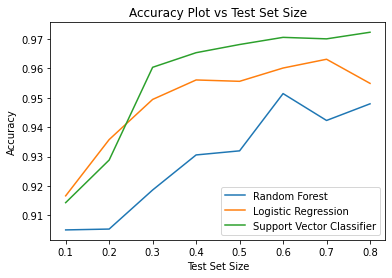

In [329]:

from sklearn.svm import SVC
# Create a support vector classifier model
svc_model = SVC()
# Evaluate the support vector classifier model with different values of size
svc_accs = []
for size in sizes:
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_train['Text'], df_train['Category'], train_size=size, random_state=42)
    acc, y_pred, y_test = evaluate_model(svc_model, tfidf, X_train, X_test, y_train, y_test)
    svc_accs.append(acc)
    print('Support vector classifier accuracy score for size {}: {}'.format(size, acc))

# Plot the relationship between accuracy and test set size
plt.plot(sizes, rf_accs, label='Random Forest')
plt.plot(sizes, lr_accs, label='Logistic Regression')
plt.plot(sizes, svc_accs, label='Support Vector Classifier')
plt.title('Accuracy Plot vs Test Set Size')
plt.xlabel('Test Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Supervised learning methods give better accuracy with right Train/Test ratio. Logistic Regression gives maximum accuracy with 70% data where as 
Random Forest gives maxium accuracy at 60% of Train data.  Support Vector Machine accuracy becomes constant after 80%.


### References

1. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. Code References
    1. https://www.kaggle.com/competitions/learn-ai-bbc/code
    2. https://www.kaggle.com/code/shaochiehlin/bbc-text-classification
    3. https://www.kaggle.com/code/vinothmdev/notebook314889d38f